# Using MLP to Predict Health Score based on Lifestyle factors


In [98]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV



df = pd.read_csv("synthetic_health_data.csv")

print(df.shape)
display(df.head())
display(df.describe(include="all").T)




(1000, 8)


,Age,BMI,Exercise_Frequency,Diet_Quality,Sleep_Hours,Smoking_Status,Alcohol_Consumption,Health_Score
0,45.960570,31.996777,5,55.403270,7.300359,0,2.834707,70.542122
1,38.340828,29.623168,6,41.838357,7.012419,1,7.199517,57.244637
2,47.772262,25.298152,5,76.904948,6.028641,1,4.097944,96.333722
3,58.276358,21.765316,2,49.756767,5.802714,1,3.649377,61.321783
4,37.190160,28.491117,2,44.218737,7.912548,0,2.839795,67.175894


,count,mean,std,min,25%,50%,75%,max
Age,1000.0,40.231985,11.750591,1.104792,32.228916,40.303607,47.775327,86.232778
BMI,1000.0,25.354181,4.987272,10.298057,21.968792,25.315386,28.644411,40.965538
Exercise_Frequency,1000.0,2.888000,1.995354,0.000000,1.000000,3.000000,5.000000,6.000000
Diet_Quality,1000.0,69.952977,14.972061,19.907497,59.945481,69.975151,80.527839,110.265186
Sleep_Hours,1000.0,6.973135,1.517218,2.431107,5.903351,6.990847,8.054595,11.638962
Smoking_Status,1000.0,0.499000,0.500249,0.000000,0.000000,0.000000,1.000000,1.000000
Alcohol_Consumption,1000.0,3.079377,2.084564,-3.592506,1.644111,3.064261,4.489293,11.105100
Health_Score,1000.0,85.479947,13.633845,29.106017,76.430819,87.498996,99.762644,100.000000


In [99]:

target_col = "Health_Score"



y = df[target_col]


X = df.drop(columns=[target_col])


X = X.select_dtypes(include=[np.number])

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (1000, 7)
Target shape: (1000,)


In [100]:
binary_cols = ["Smoking_Status"]        # stays 0/1
target_col = "Health_Score"            # regression target

# =====================================================
# 2. Feature engineering (neural-net friendly)
#    Do this BEFORE defining numeric_cols
# =====================================================

# --- Keep original features: BMI, Diet_Quality, Sleep_Hours,
#     Alcohol_Consumption, Exercise_Frequency, Age, Smoking_Status ---

# Stable, meaningful interactions (NO divisions)
df["Diet_Exercise"] = df["Diet_Quality"] * df["Exercise_Frequency"]
df["Sleep_Exercise"] = df["Sleep_Hours"] * df["Exercise_Frequency"]

# Simple nonlinearities
df["BMI_sq"] = df["BMI"] ** 2
df["Alcohol_sq"] = df["Alcohol_Consumption"] ** 2

# (If you had any old ratio features like BMI_Diet_Quality, Alc_Execercise,
#  age_sleep, Exercise_Sleep, I recommend dropping them:)
for col in ["BMI_Diet_Quality", "Diet_Sleep", "Alc_Execercise",
            "age_sleep", "Exercise_Sleep", "Diet_Quality_BMI"]:
    if col in df.columns:
        df = df.drop(columns=[col])

# =====================================================
# 3. Define numeric / binary columns AFTER feature eng
# =====================================================
numeric_cols = [c for c in df.columns if c not in binary_cols + [target_col]]

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



# =====================================================
# 4. Preprocessing: scale numeric, passthrough binary
# =====================================================
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("bin", "passthrough", binary_cols),
    ]
)

# =====================================================
# 5. Baseline: Linear Regression
# =====================================================
baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)

print("=== Baseline: Linear Regression ===")
print(f"MAE : {mae_base:.4f}")
print(f"RMSE: {rmse_base:.4f}")
print(f"R²  : {r2_base:.4f}\n")

=== Baseline: Linear Regression ===
MAE : 4.6798
RMSE: 6.0319
R²  : 0.8134



# Baseline Model

In [101]:
baseline = LinearRegression()
baseline.fit(X_train, y_train)

y_pred_base = baseline.predict(X_test)

mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)

print("=== Baseline: Linear Regression ===")
print(f"MAE : {mae_base:.4f}")
print(f"RMSE: {rmse_base:.4f}")
print(f"R²  : {r2_base:.4f}")


=== Baseline: Linear Regression ===
MAE : 4.6798
RMSE: 6.0319
R²  : 0.8134


# Base MLP Model

In [107]:
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),  
    activation="relu",
    solver="adam",
    learning_rate_init=0.0005,         
    alpha=0.003,                         
    batch_size=64,                      
    max_iter=5000,                     
    early_stopping=True,                
    validation_fraction=0.15,
    n_iter_no_change=20,
    random_state=42
)


mlp.fit(X_train, y_train_norm)

y_pred_mlp = mlp.predict(X_test)

mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
r2_mlp = r2_score(y_test, y_pred_mlp)

print("\n=== MLP Regressor ===")
print(f"MAE : {mae_mlp:.4f}")
print(f"RMSE: {rmse_mlp:.4f}")
print(f"R²  : {r2_mlp:.4f}")



=== MLP Regressor ===
MAE : 84.5792
RMSE: 85.7053
R²  : -36.6761


# MLP Model with CV search

In [103]:
# Your existing pipeline
mlp_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", MLPRegressor(
        activation="relu",
        solver="adam",
        max_iter=2000,
        early_stopping=True,       
        n_iter_no_change=20,
        random_state=42,
    ))
])

param_grid = {
    "model__hidden_layer_sizes": [
        (128, 64),
        (256, 128, 64),
        (128, 64, 32),
    ],
    "model__learning_rate_init": [0.0005, 0.0008],
    "model__alpha": [0.0003, 0.0005, 0.001],
}

grid = GridSearchCV(
    estimator=mlp_pipe,
    param_grid=param_grid,
    scoring="r2",      
    cv=5,
    n_jobs=-1,
    verbose=2,
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

# Evaluate on test set
best_mlp = grid.best_estimator_
y_pred_mlp = best_mlp.predict(X_test)

mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
r2_mlp = r2_score(y_test, y_pred_mlp)

print("\n=== Best MLP from GridSearch ===")
print(f"MAE : {mae_mlp:.4f}")
print(f"RMSE: {rmse_mlp:.4f}")
print(f"R²  : {r2_mlp:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END model__alpha=0.0003, model__hidden_layer_sizes=(128, 64), model__learning_rate_init=0.0008; total time=   1.3s
[CV] END model__alpha=0.0003, model__hidden_layer_sizes=(128, 64), model__learning_rate_init=0.0008; total time=   1.3s
[CV] END model__alpha=0.0003, model__hidden_layer_sizes=(128, 64), model__learning_rate_init=0.0008; total time=   1.4s
[CV] END model__alpha=0.0003, model__hidden_layer_sizes=(128, 64), model__learning_rate_init=0.0005; total time=   2.1s
[CV] END model__alpha=0.0003, model__hidden_layer_sizes=(128, 64), model__learning_rate_init=0.0005; total time=   2.2s
[CV] END model__alpha=0.0003, model__hidden_layer_sizes=(128, 64), model__learning_rate_init=0.0005; total time=   2.3s
[CV] END model__alpha=0.0003, model__hidden_layer_sizes=(128, 64), model__learning_rate_init=0.0005; total time=   2.4s
[CV] END model__alpha=0.0003, model__hidden_layer_sizes=(128, 64), model__learning_rate_init=0.0005

In [104]:
best_mlp = grid.best_estimator_

# Train performance
y_pred_train = best_mlp.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)

# Test performance (you already did, but recomputing for clarity)
y_pred_test = best_mlp.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)

print("=== Best MLP: Train vs Test ===")
print(f"R² train: {r2_train:.4f}")
print(f"R² test : {r2_test:.4f}")


=== Best MLP: Train vs Test ===
R² train: 0.9342
R² test : 0.8800


In [105]:
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# =========================================
# 1. LightGBM model with same preprocessing
# =========================================

lgbm = LGBMRegressor(
    objective="huber",
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

lgbm_pipe = Pipeline(steps=[
    ("preprocess", preprocess),   # same ColumnTransformer you use for MLP
    ("model", lgbm)
])

lgbm_pipe.fit(X_train, y_train)
y_pred_lgbm = lgbm_pipe.predict(X_test)

mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print("=== LightGBM ===")
print(f"MAE : {mae_lgbm:.4f}")
print(f"RMSE: {rmse_lgbm:.4f}")
print(f"R²  : {r2_lgbm:.4f}\n")

# =========================================
# 2. Tuned MLP (best from your GridSearch)
# =========================================

best_mlp = grid.best_estimator_   # assuming you still have this from GridSearchCV
y_pred_mlp = best_mlp.predict(X_test)

mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
r2_mlp = r2_score(y_test, y_pred_mlp)

print("=== MLP (Best from GridSearch) ===")
print(f"MAE : {mae_mlp:.4f}")
print(f"RMSE: {rmse_mlp:.4f}")
print(f"R²  : {r2_mlp:.4f}\n")

# =========================================
# 3. Simple Ensemble: average of MLP + LightGBM
# =========================================

y_pred_ens = 0.85 * y_pred_mlp + 0.15 * y_pred_lgbm

mae_ens = mean_absolute_error(y_test, y_pred_ens)
rmse_ens = np.sqrt(mean_squared_error(y_test, y_pred_ens))
r2_ens = r2_score(y_test, y_pred_ens)

print("=== Ensemble (0.5 * MLP + 0.5 * LightGBM) ===")
print(f"MAE : {mae_ens:.4f}")
print(f"RMSE: {rmse_ens:.4f}")
print(f"R²  : {r2_ens:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2305
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 11
[LightGBM] [Info] Start training from score 85.492030
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/garrett/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


=== Final Evaluation Table ===
                                    MAE    RMSE      R²
Linear Regression                4.6798  6.0319  0.8134
MLP (Tuned)                      3.5502  4.8363  0.8800
LightGBM                         4.5081  6.5155  0.7823
Ensemble (0.85 MLP + 0.15 LGBM)  3.5147  4.8341  0.8801


/Users/garrett/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/var/folders/3d/xxp_4k2j25b2krxn_frbt2v00000gn/T/ipykernel_33699/2998100903.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_final_formatted = df_final.applymap(lambda x: f"{x:.4f}")


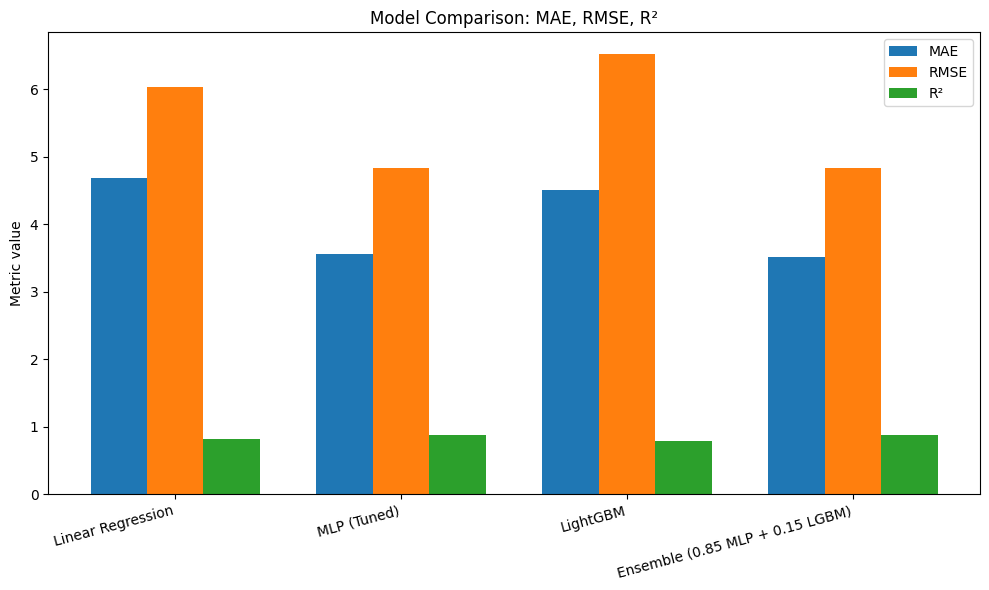

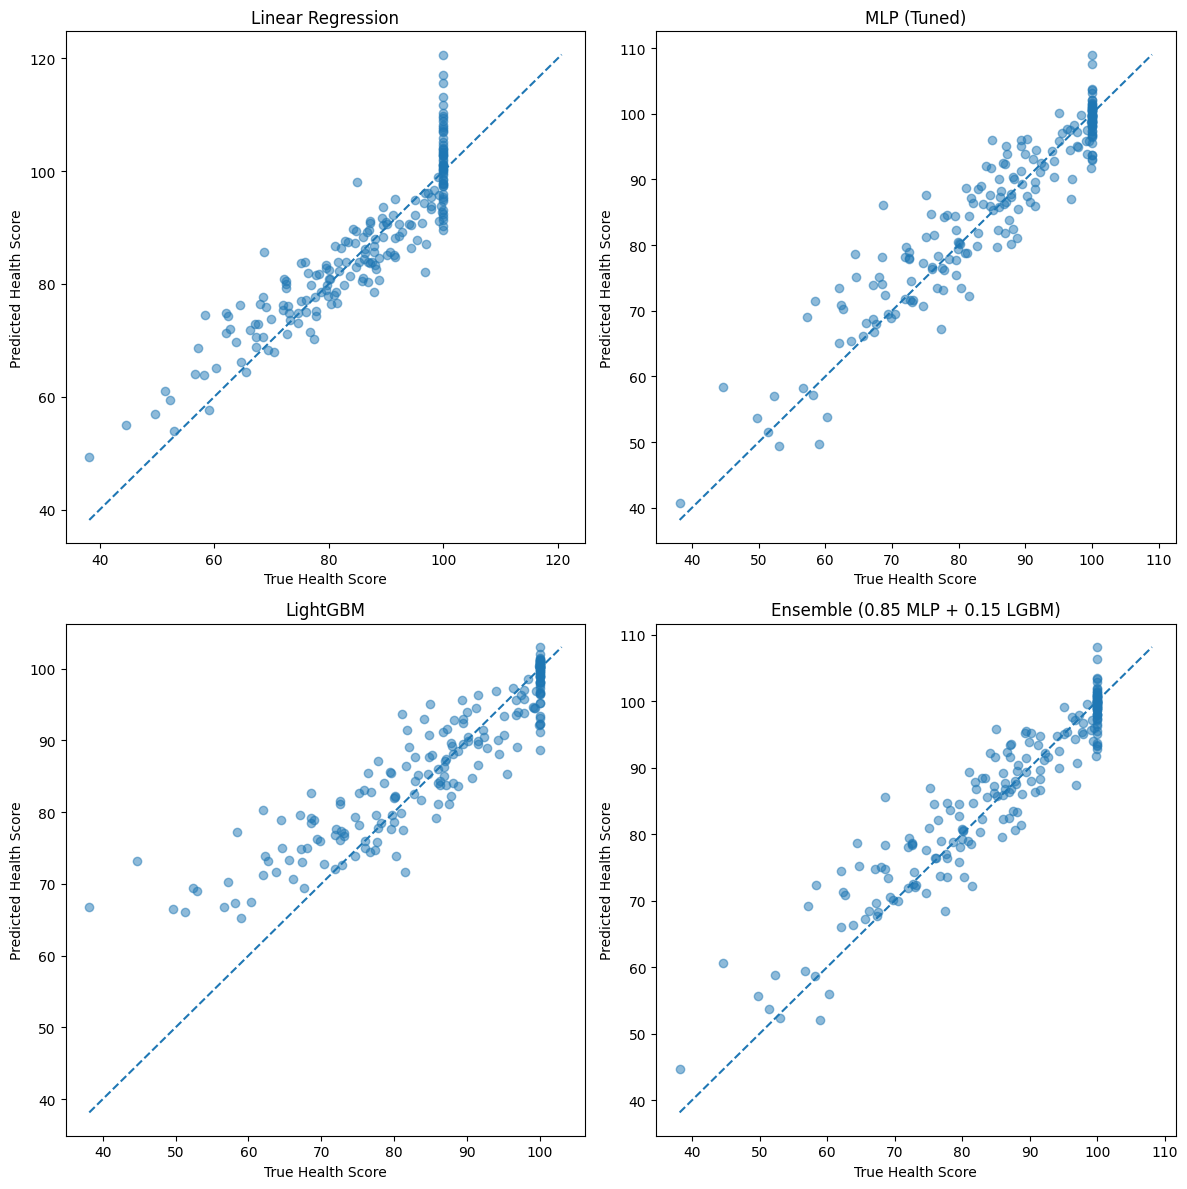

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ======================================================
# 1. Get predictions from all models
# ======================================================
y_pred_base = baseline.predict(X_test)        # Linear Regression
y_pred_mlp  = best_mlp.predict(X_test)        # Tuned MLP
y_pred_lgbm = lgbm_pipe.predict(X_test)       # LightGBM

# Ensemble (0.85 * MLP + 0.15 * LGBM)
w_mlp = 0.85
w_lgbm = 0.15
y_pred_ens = w_mlp * y_pred_mlp + w_lgbm * y_pred_lgbm

# ======================================================
# 2. Metrics helper
# ======================================================
def get_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    return mae, rmse, r2

metrics_raw = {
    "Linear Regression": get_metrics(y_test, y_pred_base),
    "MLP (Tuned)": get_metrics(y_test, y_pred_mlp),
    "LightGBM": get_metrics(y_test, y_pred_lgbm),
    "Ensemble (0.85 MLP + 0.15 LGBM)": get_metrics(y_test, y_pred_ens),
}

# ======================================================
# 3. Metrics table (pretty)
# ======================================================
df_final = pd.DataFrame(metrics_raw, index=["MAE", "RMSE", "R²"]).T
df_final_formatted = df_final.applymap(lambda x: f"{x:.4f}")

print("=== Final Evaluation Table ===")
print(df_final_formatted)

# ======================================================
# 4. Bar chart of metrics
# ======================================================
# Use raw numeric df for plotting
df_plot = df_final.copy()
models = df_plot.index.tolist()
metrics_names = df_plot.columns.tolist()

x = np.arange(len(models))
width = 0.25  # bar width

plt.figure(figsize=(10, 6))

# One bar group per metric
for i, metric in enumerate(metrics_names):
    plt.bar(x + i * width, df_plot[metric].values, width, label=metric)

plt.xticks(x + width, models, rotation=15, ha="right")
plt.ylabel("Metric value")
plt.title("Model Comparison: MAE, RMSE, R²")
plt.legend()
plt.tight_layout()
plt.show()

# ======================================================
# 5. Predicted vs True plots for all models
# ======================================================
plt.figure(figsize=(12, 12))

models_preds = {
    "Linear Regression": y_pred_base,
    "MLP (Tuned)": y_pred_mlp,
    "LightGBM": y_pred_lgbm,
    "Ensemble (0.85 MLP + 0.15 LGBM)": y_pred_ens,
}

for i, (name, y_pred) in enumerate(models_preds.items(), start=1):
    plt.subplot(2, 2, i)
    plt.scatter(y_test, y_pred, alpha=0.5)
    # Reference diagonal
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
    plt.xlabel("True Health Score")
    plt.ylabel("Predicted Health Score")
    plt.title(name)

plt.tight_layout()
plt.show()


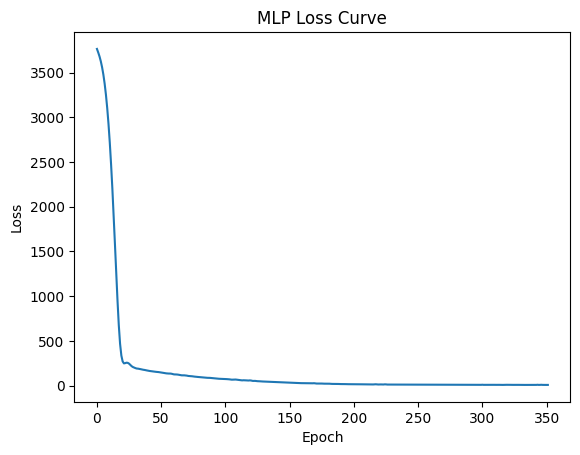

In [83]:
plt.plot(best_mlp.named_steps["model"].loss_curve_)
plt.title("MLP Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


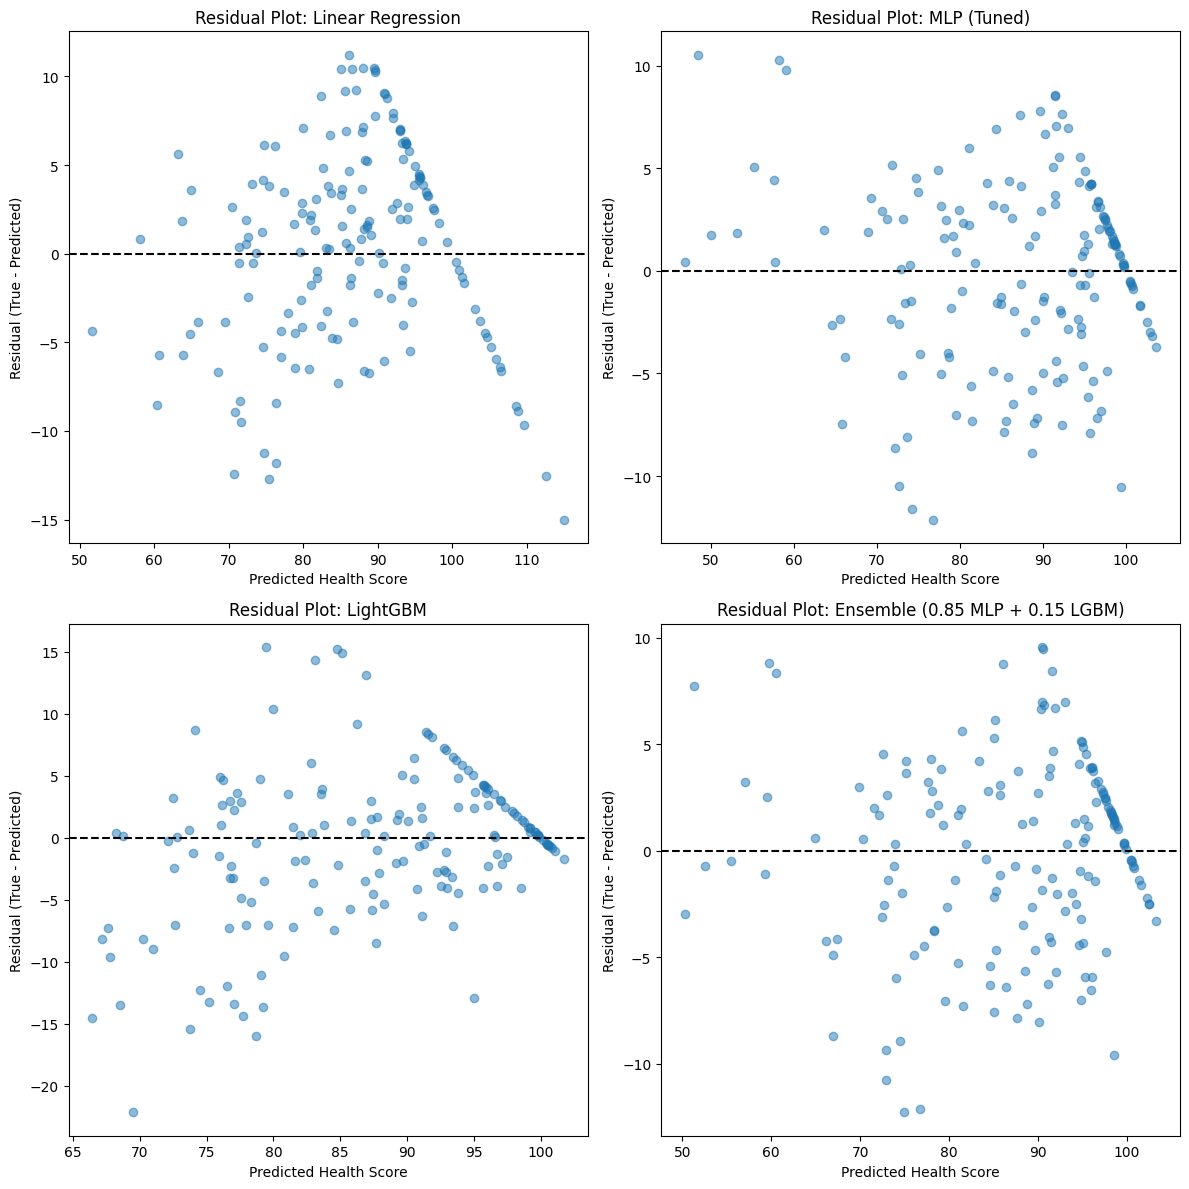

In [85]:
import matplotlib.pyplot as plt

# Compute residuals
res_base = y_test - y_pred_base
res_mlp  = y_test - y_pred_mlp
res_lgbm = y_test - y_pred_lgbm
res_ens  = y_test - y_pred_ens

residuals_dict = {
    "Linear Regression": res_base,
    "MLP (Tuned)": res_mlp,
    "LightGBM": res_lgbm,
    "Ensemble (0.85 MLP + 0.15 LGBM)": res_ens
}

preds_dict = {
    "Linear Regression": y_pred_base,
    "MLP (Tuned)": y_pred_mlp,
    "LightGBM": y_pred_lgbm,
    "Ensemble (0.85 MLP + 0.15 LGBM)": y_pred_ens
}

plt.figure(figsize=(12, 12))

for i, (name, res) in enumerate(residuals_dict.items(), start=1):
    plt.subplot(2, 2, i)
    plt.scatter(preds_dict[name], res, alpha=0.5)
    plt.axhline(0, linestyle="--", color="black")
    plt.xlabel("Predicted Health Score")
    plt.ylabel("Residual (True - Predicted)")
    plt.title(f"Residual Plot: {name}")

plt.tight_layout()
plt.show()


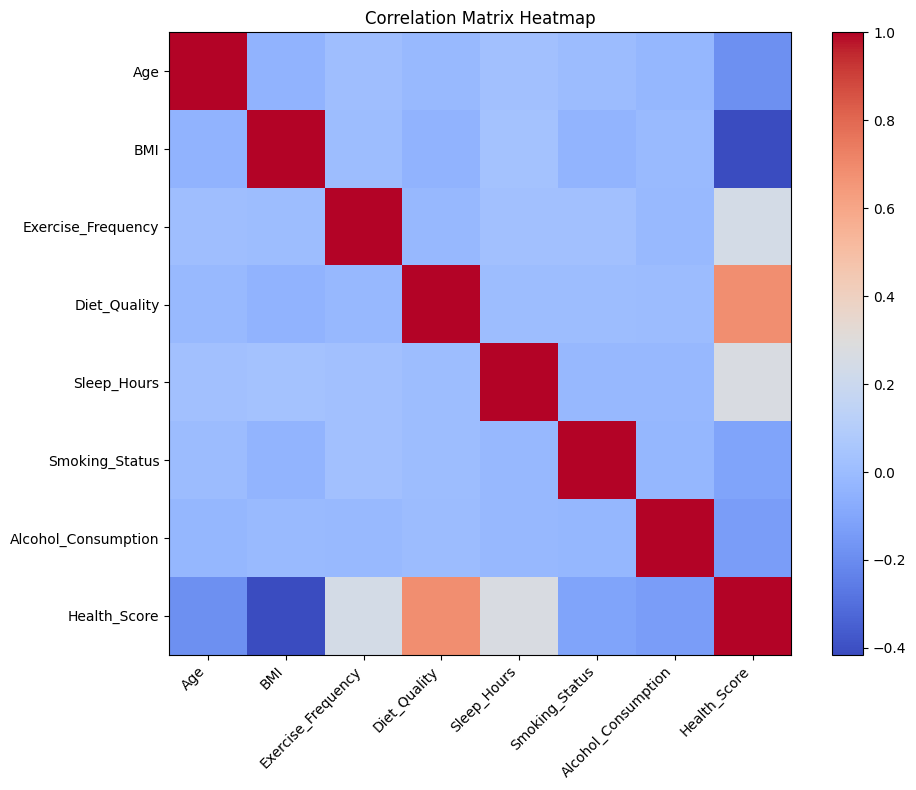

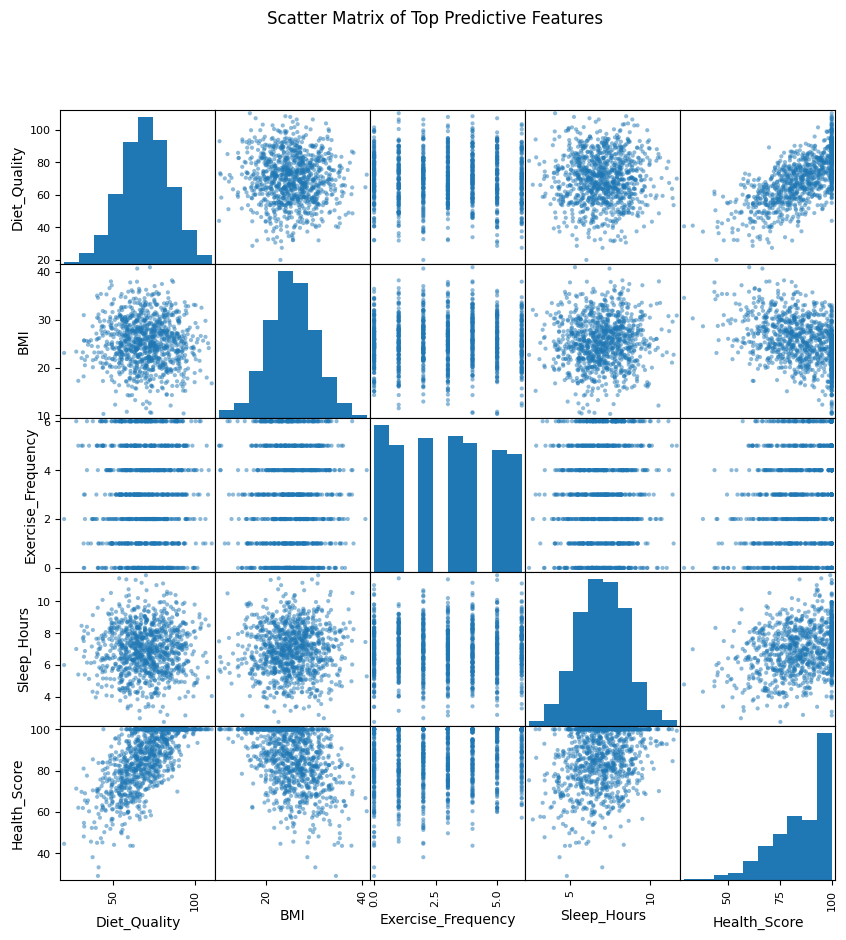

,feature,importance,std
3,Diet_Quality,198.871723,19.649164
1,BMI,71.655324,5.104191
2,Exercise_Frequency,32.731291,3.848085
4,Sleep_Hours,30.664953,3.431533
0,Age,14.571378,2.638697
5,Smoking_Status,7.270849,1.280638
6,Alcohol_Consumption,2.985921,1.869269


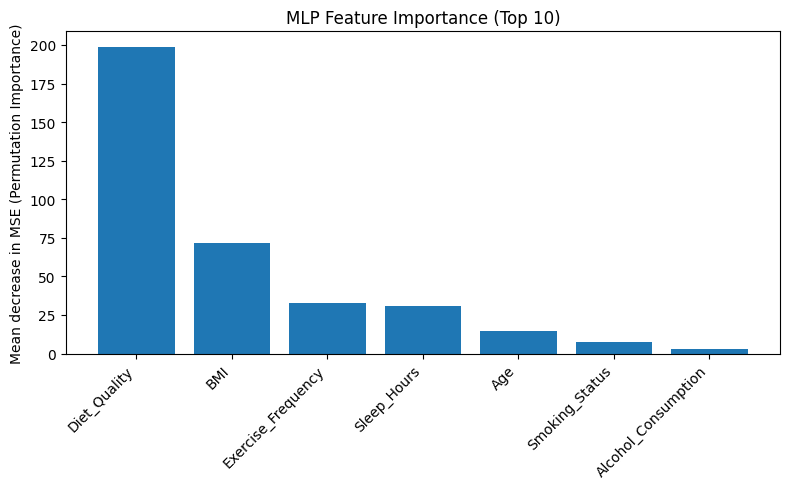

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from pandas.plotting import scatter_matrix


df = pd.read_csv("synthetic_health_data.csv")

corr = df.corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()



top_features = ["Diet_Quality", "BMI", "Exercise_Frequency", "Sleep_Hours", "Health_Score"]

scatter_matrix(df[top_features], figsize=(10, 10), diagonal='hist')
plt.suptitle("Scatter Matrix of Top Predictive Features")
plt.show()



X_df = df.drop(columns=["Health_Score"]).select_dtypes(include=[np.number])
y = df["Health_Score"]

feature_names = X_df.columns

result = permutation_importance(
    mlp,
    X_test_scaled,
    y_test,
    n_repeats=20,
    random_state=42,
    scoring="neg_mean_squared_error"
)

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": result.importances_mean,
    "std": result.importances_std
}).sort_values("importance", ascending=False)

display(importance_df)

# Plot top 10
top_imp = importance_df.head(10)

plt.figure(figsize=(8, 5))
plt.bar(top_imp["feature"], top_imp["importance"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean decrease in MSE (Permutation Importance)")
plt.title("MLP Feature Importance (Top 10)")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Load and prepare data (replace with your file path if needed)
df = pd.read_csv('synthetic_health_data.csv')  # Or load from string/attachment if in a tool env
X = df.drop('Health_Score', axis=1).values
y = df['Health_Score'].values

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# FT-Transformer Model
class FTTransformer(nn.Module):
    def __init__(self, num_features=7, embed_dim=32, num_layers=3, num_heads=4, dropout=0.1):
        super(FTTransformer, self).__init__()
        # Feature tokenizer: Linear projection for numerical features
        self.feature_tokenizer = nn.Linear(1, embed_dim)  # Applied per feature
        # Positional encoding (simple learnable)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_features, embed_dim))
        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Output head for regression
        self.head = nn.Sequential(
            nn.Linear(embed_dim * num_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # Tokenize: Treat each feature as a "token" and embed (x shape: batch x num_features)
        x = x.unsqueeze(-1)  # batch x num_features x 1
        x = self.feature_tokenizer(x)  # batch x num_features x embed_dim
        x = x + self.pos_embedding  # Add positional info
        # Transformer
        x = self.transformer(x)  # batch x num_features x embed_dim
        # Flatten and predict
        x = x.reshape(x.size(0), -1)  # batch x (num_features * embed_dim)
        return self.head(x)

# Instantiate
model = FTTransformer()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 reg for overfitting

# Training loop (add early stopping in production)
epochs = 300
for epoch in range(epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

# Evaluate
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy().squeeze()
r2 = r2_score(y_test, y_pred)
print(f'Test R²: {r2:.4f}')

# Optional: Clip predictions if scores are bounded (0-100)
y_pred_clipped = np.clip(y_pred, 0, 100)
r2_clipped = r2_score(y_test, y_pred_clipped)
print(f'Clipped Test R²: {r2_clipped:.4f}')

# -------------------------------
# 1. Predicted vs True Plot
# -------------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Health Score")
plt.ylabel("Predicted Health Score")
plt.title("MLP: Predicted vs True")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.tight_layout()
plt.show()

# -------------------------------
# 2. Residuals Histogram
# -------------------------------
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, alpha=0.7)
plt.title("Residuals Distribution (MLP)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# -------------------------------
# 3. Residuals vs Predicted Plot
# -------------------------------
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Health Score")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

Epoch 50, Loss: 27.0806


KeyboardInterrupt: 

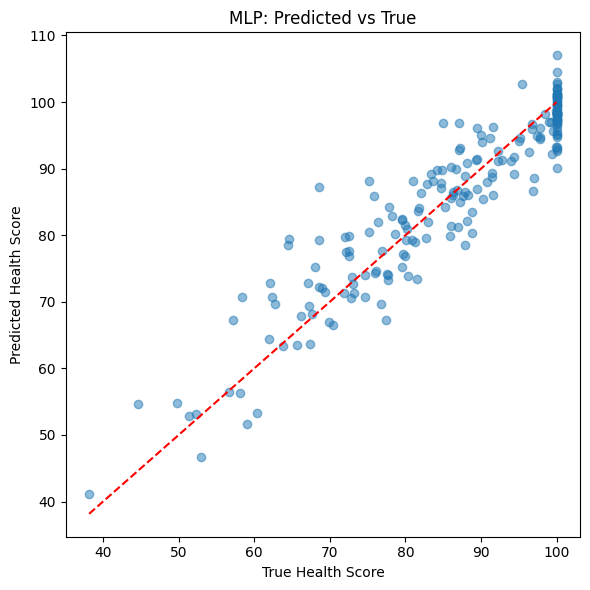

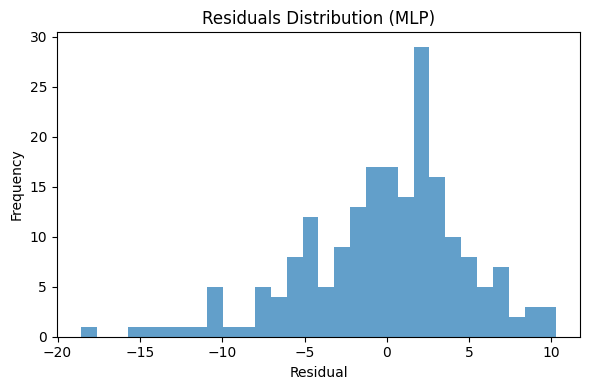

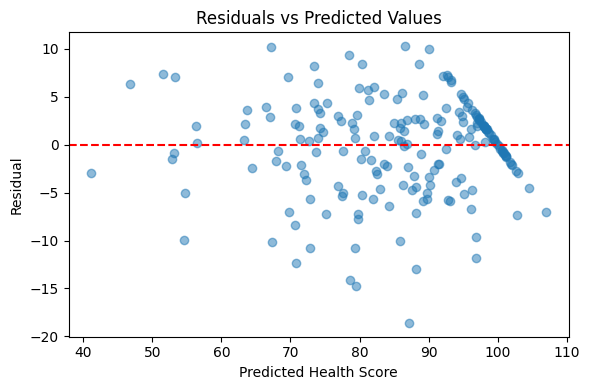

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("synthetic_health_data.csv")

# Set target column
target_col = "Health_Score"
X = df.drop(columns=[target_col]).select_dtypes(include=[np.number])
y = df[target_col]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train best MLP model
mlp = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64),
    activation="relu",
    solver="adam",
    learning_rate_init=0.001,
    batch_size=32,
    alpha=0.001,
    max_iter=2000,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=20,
    random_state=42
)

mlp.fit(X_train_scaled, y_train)
y_pred = mlp.predict(X_test_scaled)

# -------------------------------
# 1. Predicted vs True Plot
# -------------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Health Score")
plt.ylabel("Predicted Health Score")
plt.title("MLP: Predicted vs True")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.tight_layout()
plt.show()

# -------------------------------
# 2. Residuals Histogram
# -------------------------------
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, alpha=0.7)
plt.title("Residuals Distribution (MLP)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# -------------------------------
# 3. Residuals vs Predicted Plot
# -------------------------------
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Health Score")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

df = pd.read_csv("synthetic_health_data.csv")

X = df.drop("Health_Score", axis=1).values.astype(np.float32)
y = df["Health_Score"].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Make y 2D (no scaling needed)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

model = TabNetRegressor(
    n_d=64, n_a=64,
    n_steps=5,
    gamma=1.3,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.02),
    mask_type="entmax",
    verbose=10,
    seed=42
    # No pretraining_ratio — works on all versions
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=["rmse"],
    max_epochs=300,
    patience=50,
    batch_size=512,
    virtual_batch_size=128
)

preds = np.clip(model.predict(X_test).flatten(), 0, 100)
print("Final clipped R² :", r2_score(y_test.flatten(), preds))

/Users/garrett/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 7050.22949| val_0_rmse: 1337.99785|  0:00:00s
epoch 10 | loss: 783.02423| val_0_rmse: 688.66338|  0:00:00s
epoch 20 | loss: 157.09354| val_0_rmse: 190.94435|  0:00:01s
epoch 30 | loss: 59.25634| val_0_rmse: 89.26312|  0:00:02s
epoch 40 | loss: 33.34079| val_0_rmse: 32.19038|  0:00:03s
epoch 50 | loss: 29.8441 | val_0_rmse: 36.06938|  0:00:03s
epoch 60 | loss: 27.18755| val_0_rmse: 30.64503|  0:00:04s
epoch 70 | loss: 25.14284| val_0_rmse: 18.12573|  0:00:05s
epoch 80 | loss: 21.25605| val_0_rmse: 14.50453|  0:00:05s
epoch 90 | loss: 23.40036| val_0_rmse: 15.77068|  0:00:06s
epoch 100| loss: 25.17947| val_0_rmse: 14.12024|  0:00:07s
epoch 110| loss: 20.76217| val_0_rmse: 16.23085|  0:00:08s
epoch 120| loss: 20.31756| val_0_rmse: 9.70945 |  0:00:08s
epoch 130| loss: 23.01786| val_0_rmse: 9.63275 |  0:00:09s
epoch 140| loss: 18.7859 | val_0_rmse: 8.88774 |  0:00:10s
epoch 150| loss: 16.55565| val_0_rmse: 7.46112 |  0:00:10s
epoch 160| loss: 15.06024| val_0_rmse: 6.95298 |

/Users/garrett/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
